comment out to force cpu use

In [9]:
import os
from __future__ import print_function
import matplotlib
import matplotlib.pyplot as plt
# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import time
import pandas as pd
import seaborn as sns
%matplotlib inline 

# Simple Test

In [67]:
# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

[[22. 28.]
 [49. 64.]]


In [23]:
def get_times(maximum_time):

    device_times = {
        "/gpu:0":[],
        "/cpu:0":[]
    }
    
    matrix_sizes = range(500,50000,50)

    for size in matrix_sizes:
        
        for device_name in device_times.keys():

            shape = (size,size)
            data_type = tf.float16
            
            with tf.device(device_name):
                r1 = tf.random_uniform(shape=shape, minval=0, maxval=1, dtype=data_type)
                r2 = tf.random_uniform(shape=shape, minval=0, maxval=1, dtype=data_type)
                dot_operation = tf.matmul(r2, r1)

            with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
                start_time = time.time()
                result = session.run(dot_operation)
                time_taken = time.time() - start_time
                device_times[device_name].append(time_taken)

            if time_taken > maximum_time:
                return device_times

device_times = get_times(5)
gpu_times = device_times["/gpu:0"]
cpu_times = device_times["/cpu:0"]

In [50]:
matrix_sizes = range(500,50000,50)[:len(gpu_times)]
gpu = pd.DataFrame({'Time':gpu_times, 'Type': 'GPU', 'Size': matrix_sizes})
cpu = pd.DataFrame({'Time':cpu_times, 'Type': 'CPU', 'Size': matrix_sizes})
comp = pd.concat([gpu,cpu])
comp['Unit'] = 'subject'

/home/shiwang/miniconda3/envs/carnd-term1/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


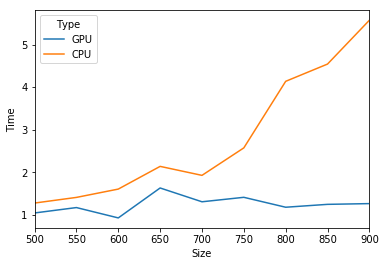

In [51]:
sns.tsplot(data=comp, time="Size", condition="Type", value="Time", unit = 'Unit')

# Comparison on MNIST with CNN

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[]

In [3]:
import numpy as np
import tensorflow as tf
np.random.seed(123)
tf.set_random_seed(123)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

batch_size = 128
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [4]:
X_train.shape

(60000, 28, 28, 1)

In [5]:
Y_train.shape

(60000, 10)

In [6]:
model = Sequential()
model.add(Convolution2D(32, (6, 6), activation='relu', input_shape=(28,28,1)))
model.add(Convolution2D(20, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

In [7]:
#SVG(model_to_dot(model).create(prog='dot', format='svg'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 23, 23, 32)        1184      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 20)        23060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 20)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 9, 20)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1620)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               207488    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

## GPU (10 epochs)

In [61]:
%%time
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X_train, Y_train,
          batch_size = batch_size, 
          epochs = 10, 
          verbose = 1,
          validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 86us/step - loss: 0.0809 - acc: 0.9761 - val_loss: 0.0373 - val_acc: 0.9881
Epoch 2/10
60000/60000 [==============================] - 5s 76us/step - loss: 0.0573 - acc: 0.9825 - val_loss: 0.0307 - val_acc: 0.9895
Epoch 3/10
60000/60000 [==============================] - 5s 76us/step - loss: 0.0447 - acc: 0.9867 - val_loss: 0.0286 - val_acc: 0.9912
Epoch 4/10
60000/60000 [==============================] - 5s 76us/step - loss: 0.0389 - acc: 0.9881 - val_loss: 0.0243 - val_acc: 0.9922
Epoch 5/10
60000/60000 [==============================] - 5s 76us/step - loss: 0.0335 - acc: 0.9895 - val_loss: 0.0231 - val_acc: 0.9918
Epoch 6/10
60000/60000 [==============================] - 5s 76us/step - loss: 0.0315 - acc: 0.9903 - val_loss: 0.0210 - val_acc: 0.9935
Epoch 7/10
60000/60000 [==============================] - 5s 76us/step - loss: 0.0273 - acc: 0.9915 - val_loss: 0.0228 - val_acc

In [62]:
model.save('./model/model_mnist_cnn.h5')
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.02628254831110653
Test accuracy: 0.9928


## CPU (one epoch)

In [8]:
%%time
model.reset_states()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X_train, Y_train,
      batch_size = batch_size, 
      epochs = 1, 
      verbose = 1,
      validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 77s 1ms/step - loss: 0.2499 - acc: 0.9229 - val_loss: 0.0553 - val_acc: 0.9826
CPU times: user 7min 56s, sys: 1min 10s, total: 9min 6s
Wall time: 1min 17s
